# Slicing

In [1]:
# import
import sys
sys.path.append('../')

import logging
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Set up the logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [2]:
mri_1_label = nib.load('../MRI/Labels/final/LabelsDani.nii')
mri_1_label_data = mri_1_label.get_fdata()
mri_1_label_data.shape

(606, 864, 61)

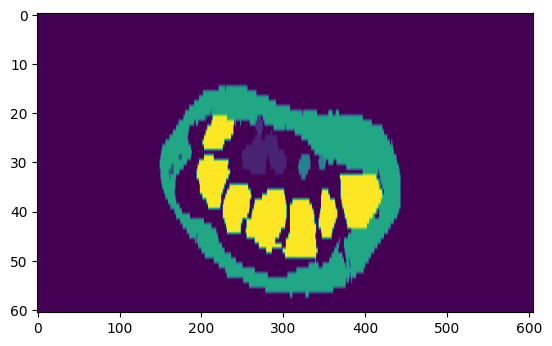

In [3]:
# Visualize an image slice using simpleITK
import SimpleITK as sitk

# Load the image data
volume = sitk.ReadImage('../MRI/Labels/final/LabelsDani.nii')
img_array = sitk.GetArrayFromImage(volume)

# Take a 2D image slice
slice_num = 670
slice = img_array[:, slice_num, :]
plt.imshow(slice, aspect=6)
plt.show()

In [4]:
volume_size = volume.GetSize()
img_size = img_array.shape

print(f" {volume_size=},\n {img_size=}")

 volume_size=(606, 864, 61),
 img_size=(61, 864, 606)


In [5]:
trans_imfusion = \
[[   0.915608359793373,   -0.333254189335102,    0.224951054158662,                  -10],
 [    0.21138484580494,  -0.0769377913064519,   -0.974370064827993,                 -6.5],
 [   0.342020143325669,    0.939692620785908, 5.22225573892876e-10,                   47],
 [                   0,                    0,                    0,                    1]]


In [6]:
# Euler transformation
# Rotation is defined by three rotations around z1, x2, z2 axis
th_z1 = 0
th_x2 = 0

# Translation vector
t = np.array(volume.GetOrigin())

# transformation simplified at z2=0 since this rotation is never performed
eul_tr = np.array([ [np.cos(th_z1), -np.sin(th_z1)*np.cos(th_x2),  np.sin(th_z1)*np.sin(th_x2), t[0]],
                    [np.sin(th_z1),  np.cos(th_z1)*np.cos(th_x2), -np.cos(th_z1)*np.sin(th_x2), t[1]],
                    [0,              np.sin(th_x2),                np.cos(th_x2),               t[2]],
                    [0,              0,                            0,                           1]])


In [7]:
# convert imFusion transformation matrix to sitk transformation matrix
sitk_transform = sitk.AffineTransform(3)
sitk_transform.SetMatrix(np.array(eul_tr)[:3,:3].flatten())
sitk_transform.GetMatrix()

(1.0, -0.0, 0.0, 0.0, 1.0, -0.0, 0.0, 0.0, 1.0)

In [8]:
# Define plane's coordinate system
e1 = eul_tr[0][:3] # x-coordinate of image plane
e2 = eul_tr[1][:3] # y-coordinate of image plane
e3 = eul_tr[2][:3] # normal vector of image plane
origin = eul_tr[:, -1:].flatten()[:3] # origin of the image plane
# origin = volume.GetOrigin()
# # change origin sign
# origin = (np.array(origin))
# origin[[1, 2]] = origin[[2, 1]]
print(f" {e1=},\n {e2=},\n {e3=},\n {origin=}")

# Direction for the resampler will be (e1, e2, e3) flattened
direction = np.stack([e1, e2, e3], axis=-1).flatten()
print(f" {direction=}")

 e1=array([ 1., -0.,  0.]),
 e2=array([ 0.,  1., -0.]),
 e3=array([0., 0., 1.]),
 origin=array([ -74.90050507, -106.8415451 ,  -30.        ])
 direction=array([ 1.,  0.,  0., -0.,  1.,  0.,  0., -0.,  1.])


In [9]:

# Define the size and resolution of the output image
# height of the image plane: original z size divided by the z component of the normal vector
# (cosine of the angle between the normal vector and the z axis: x-rotation)
h = int(abs(volume_size[2]//e3[2]))
# width of the image plane: original x size divided by the x component of the normal vector
# (cosine of the angle between the normal vector and the x axis: z-rotation) 
w = int(abs(volume_size[0]//e1[0]))


print(f" {h=},\n {w=}") 

 h=61,
 w=606


In [10]:
# Use SimpleITK's resampler
resampler = sitk.ResampleImageFilter()
# Extract properties from the SimpleITK Image
spacing = volume.GetSpacing()

# use reference image
# resampler.SetReferenceImage(volume)
resampler.SetOutputDirection(direction.tolist())
resampler.SetOutputOrigin(origin.tolist())
resampler.SetOutputSpacing(spacing)
resampler.SetSize((w, volume_size[1], h))
resampler.SetInterpolator(sitk.sitkNearestNeighbor)

# Resample the volume on the arbitrary plane
sliced_volume = resampler.Execute(volume)

In [11]:

# Convert the image to a numpy array
sliced_img = sitk.GetArrayFromImage(sliced_volume)
# print value range of slice
print(f"Slice value range: {np.min(sliced_img)} - {np.max(sliced_img)}")

sitk.WriteImage(sliced_volume, "../outputs/sliced_volume.nii.gz")

Slice value range: 0 - 20


In [12]:
sliced_volume_size = sliced_volume.GetSize()
sliced_img_size = sliced_img.shape

print(f" {sliced_volume_size=},\n {volume_size=},\n {sliced_img_size=},\n {img_size=}")

 sliced_volume_size=(606, 864, 61),
 volume_size=(606, 864, 61),
 sliced_img_size=(61, 864, 606),
 img_size=(61, 864, 606)


[ -74.90050507 -106.8415451   -30.        ]
(0, 0, 0)


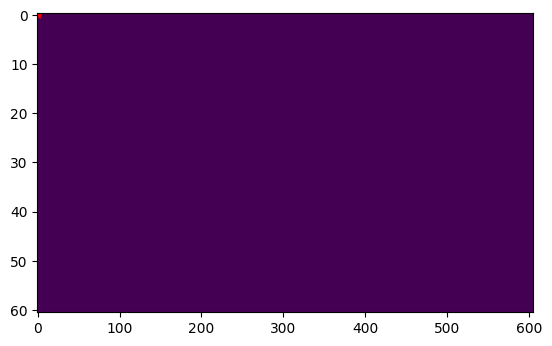

In [13]:
print(origin)
origin_idx = volume.TransformPhysicalPointToIndex(origin)
print(origin_idx)
slice = img_array[:, origin_idx[1], :]
plt.imshow(slice, aspect=6)
plt.scatter(origin_idx[0], origin_idx[2], c='r', marker='*', s=20)
plt.show()